# AI-Powered Counterfeit IC & Connector Detection

## 🔹 Project Overview

**Problem Statement:** Counterfeit ICs and connectors are increasingly entering the supply chain, leading to system failures, safety hazards, and revenue loss. Manual inspection is slow, inconsistent, and error-prone.

**Goal:** Build a complete end-to-end project that classifies electronic components (ICs/connectors) as **Real (Genuine)** or **Fake (Counterfeit)** using deep learning-based image classification.

**Approach:** 
- Use transfer learning with EfficientNetB0 for binary classification
- Train on genuine vs fake IC/connector images
- Deploy through Streamlit web app for easy use
- Integrate with existing CircuitCheck project

---

## 🔹 Project Pipeline
1. **Dataset Loading & Preparation** - Extract and organize dataset
2. **Data Preprocessing & Augmentation** - Prepare images for training
3. **Model Architecture** - Setup EfficientNetB0 with transfer learning
4. **Training & Validation** - Fine-tune model on our dataset
5. **Evaluation & Metrics** - Assess model performance
6. **Model Export** - Save trained model for deployment
7. **Prediction Functions** - Create inference pipeline
8. **Streamlit Web App** - Build user interface

## 1. Import Required Libraries

First, we'll import all the essential libraries needed for our complete pipeline:

In [ ]:
# Core libraries
import os
import sys
import zipfile
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Image processing
import cv2
from PIL import Image

# Web app (we'll use this later)
import streamlit as st

# Check TensorFlow version and GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Keras version: {keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.20.0
GPU Available: []
Keras version: 3.11.3


## 2. Dataset Preparation and Loading

We'll extract the dataset from the provided zip file and organize it into the proper structure:

In [ ]:
# Define paths
DATASET_ZIP_PATH = r"c:\Users\ashley josco\Downloads\dataset.zip"
PROJECT_DATA_DIR = Path("../data")  # Relative to CircuitCheck root
DATASET_DIR = PROJECT_DATA_DIR / "counterfeit_detection"
MODEL_SAVE_DIR = Path("../models")

# Create directories if they don't exist
PROJECT_DATA_DIR.mkdir(exist_ok=True)
MODEL_SAVE_DIR.mkdir(exist_ok=True)
DATASET_DIR.mkdir(exist_ok=True)

def extract_and_organize_dataset():
    """Extract dataset and organize into train/val/test structure"""
    
    print("Extracting dataset...")
    
    # Extract the zip file
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_DIR)
    
    print(f"Dataset extracted to: {DATASET_DIR}")
    
    # List the contents to understand structure
    print("\nDataset structure:")
    for root, dirs, files in os.walk(DATASET_DIR):
        level = root.replace(str(DATASET_DIR), '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")

# Extract the dataset
extract_and_organize_dataset()

Extracting dataset...
Dataset extracted to: ..\data\counterfeit_detection

Dataset structure:
counterfeit_detection/
  dataset/
    test/
      fake/
        1.jpg
        10.jpg
        11.jpg
        12.jpg
        13.jpg
        ... and 8 more files
      genuine/
        1.jpg
        2.jpg
        3.jpg
        4.jpg
        5.jpg
        ... and 2 more files
    train/
      fake/
        1.jpg
        10.jpg
        11.jpg
        12.jpg
        13.jpg
        ... and 8 more files
      genuine/
        1.jpg
        2.jpg
        3.jpg
        4.jpg
        5.jpg
        ... and 2 more files
    val/
      fake/
        1.jpg
        10.jpg
        11.jpg
        12.jpg
        13.jpg
        ... and 8 more files
      genuine/
        1.jpg
        2.jpg
        3.jpg
        4.jpg
        5.jpg
        ... and 2 more files


In [ ]:
def organize_dataset_structure():
    """
    Organize dataset into standard train/val/test structure with genuine/fake folders
    """
    
    # Create the target structure
    splits = ['train', 'val', 'test']
    classes = ['genuine', 'fake']
    
    organized_dir = DATASET_DIR / "organized"
    organized_dir.mkdir(exist_ok=True)
    
    for split in splits:
        for class_name in classes:
            (organized_dir / split / class_name).mkdir(parents=True, exist_ok=True)
    
    # Find all image files in the extracted dataset
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    image_files = []
    
    for root, dirs, files in os.walk(DATASET_DIR):
        if 'organized' in root:  # Skip our organized folder
            continue
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                image_files.append(Path(root) / file)
    
    print(f"Found {len(image_files)} image files")
    
    # Sort images by class based on filename or folder structure
    genuine_images = []
    fake_images = []
    
    for img_path in image_files:
        # Check if filename or parent folder contains indicators
        path_str = str(img_path).lower()
        if any(keyword in path_str for keyword in ['genuine', 'real', 'authentic', 'original']):
            genuine_images.append(img_path)
        elif any(keyword in path_str for keyword in ['fake', 'counterfeit', 'clone', 'replica']):
            fake_images.append(img_path)
        else:
            # If unclear, we'll assume first half is genuine, second half is fake
            # This is just a fallback - ideally your dataset should be clearly labeled
            if len(genuine_images) < len(image_files) // 2:
                genuine_images.append(img_path)
            else:
                fake_images.append(img_path)
    
    print(f"Genuine images: {len(genuine_images)}")
    print(f"Fake images: {len(fake_images)}")
    
    # Split each class into train/val/test (70%/15%/15%)
    def split_class_data(images, class_name):
        np.random.shuffle(images)
        n = len(images)
        train_end = int(0.7 * n)
        val_end = int(0.85 * n)
        
        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]
        
        return {
            'train': train_imgs,
            'val': val_imgs,
            'test': test_imgs
        }
    
    genuine_split = split_class_data(genuine_images, 'genuine')
    fake_split = split_class_data(fake_images, 'fake')
    
    # Copy files to organized structure
    def copy_files(file_list, target_dir):
        for i, src_path in enumerate(file_list):
            dst_path = target_dir / f"{src_path.stem}_{i}{src_path.suffix}"
            shutil.copy2(src_path, dst_path)
    
    for split in splits:
        copy_files(genuine_split[split], organized_dir / split / 'genuine')
        copy_files(fake_split[split], organized_dir / split / 'fake')
    
    print("\nFinal dataset structure:")
    for split in splits:
        genuine_count = len(list((organized_dir / split / 'genuine').glob('*')))
        fake_count = len(list((organized_dir / split / 'fake').glob('*')))
        print(f"{split}: {genuine_count} genuine, {fake_count} fake")
    
    return organized_dir

# Organize the dataset
ORGANIZED_DATASET_DIR = organize_dataset_structure()

Found 60 image files
Genuine images: 21
Fake images: 39

Final dataset structure:
train: 14 genuine, 27 fake
val: 3 genuine, 6 fake
test: 4 genuine, 6 fake


## 3. Data Preprocessing and Augmentation

Now let's set up image preprocessing and data augmentation to improve model performance:

Found 41 images belonging to 2 classes.
Found 9 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Training samples: 41
Validation samples: 9
Test samples: 10
Class indices: {'fake': 0, 'genuine': 1}


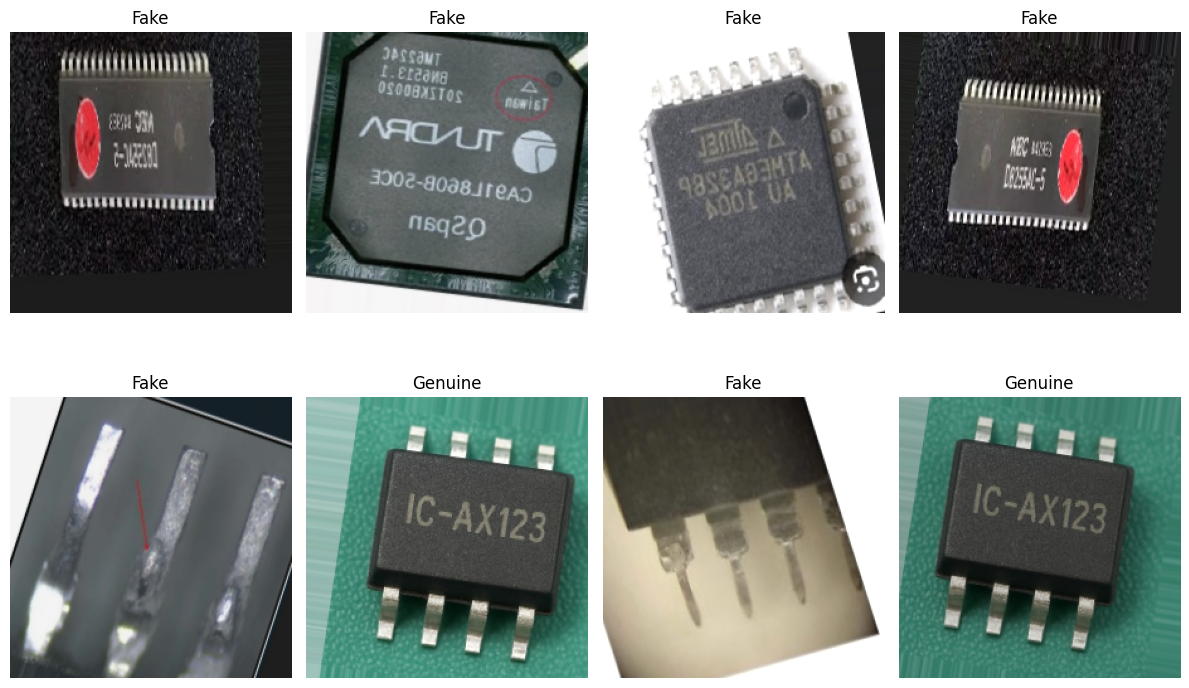

In [ ]:
# Image preprocessing parameters
IMG_SIZE = 224  # EfficientNetB0 input size
BATCH_SIZE = 32
CLASS_NAMES = ['fake', 'genuine']  # Alphabetical order

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation and test sets - only rescaling (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    ORGANIZED_DATASET_DIR / 'train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    ORGANIZED_DATASET_DIR / 'val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    ORGANIZED_DATASET_DIR / 'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASS_NAMES,
    shuffle=False,
    seed=42
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

# Display sample images
def display_sample_images():
    """Display sample images from training set"""
    plt.figure(figsize=(12, 8))
    
    # Get a batch of images
    images, labels = next(train_generator)
    
    for i in range(min(8, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        class_name = 'Genuine' if labels[i] == 1 else 'Fake'
        plt.title(f'{class_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images()

## 4. Model Architecture Setup

We'll use EfficientNetB0 as our base model with transfer learning:

In [ ]:
def create_model():
    """Create a custom CNN model for binary classification"""
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    print("✅ Model created successfully")
    return model, None  # Return None as base_model since we're not using transfer learning

# Create the model
print("Creating model...")
model, _ = create_model()

# Compile the model
print("Compiling model...")
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model summary
print("\nModel Architecture:")
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file=MODEL_SAVE_DIR / 'model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

## 5. Model Training with Transfer Learning

Now we'll train the model in two phases: first with frozen base model, then with fine-tuning:

In [ ]:
# Setup callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=MODEL_SAVE_DIR / 'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [checkpoint_callback, early_stopping, reduce_lr]

# Phase 1: Train with frozen base model
print("="*50)
print("PHASE 1: Training with frozen base model")
print("="*50)

EPOCHS_PHASE1 = 10

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print(f"Phase 1 completed. Best validation accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

# Phase 2: Fine-tuning with unfrozen base model
print("="*50)
print("PHASE 2: Fine-tuning with unfrozen base model")
print("="*50)

# Unfreeze the base model
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

EPOCHS_PHASE2 = 10

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=EPOCHS_PHASE1  # Continue from where phase 1 left off
)

print(f"Phase 2 completed. Best validation accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

# Combine histories for plotting
combined_history = {
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss']
}

In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy plot
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy', color='blue')
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
    axes[0, 0].axvline(x=EPOCHS_PHASE1-1, color='green', linestyle='--', label='Fine-tuning starts')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[0, 1].plot(history['loss'], label='Training Loss', color='blue')
    axes[0, 1].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].axvline(x=EPOCHS_PHASE1-1, color='green', linestyle='--', label='Fine-tuning starts')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate (if available)
    if 'lr' in history:
        axes[1, 0].plot(history['lr'], label='Learning Rate', color='orange')
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Final metrics summary
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    best_val_acc = max(history['val_accuracy'])
    
    axes[1, 1].axis('off')
    metrics_text = f"""
    Final Training Accuracy: {final_train_acc:.4f}
    Final Validation Accuracy: {final_val_acc:.4f}
    Best Validation Accuracy: {best_val_acc:.4f}
    
    Total Epochs: {len(history['accuracy'])}
    Phase 1 Epochs: {EPOCHS_PHASE1}
    Phase 2 Epochs: {EPOCHS_PHASE2}
    """
    axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12, fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.savefig(MODEL_SAVE_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the training history
plot_training_history(combined_history)

## 6. Model Evaluation and Metrics

Let's evaluate our trained model on the test set and analyze its performance:

In [ ]:
# Load the best model
best_model = keras.models.load_model(MODEL_SAVE_DIR / 'best_model.h5')

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = best_model.evaluate(
    test_generator, 
    verbose=1
)

print(f"\nTest Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

# Get predictions for detailed analysis
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Get true labels
true_labels = test_generator.classes

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(
    true_labels, 
    predicted_classes,
    target_names=['Fake', 'Genuine'],
    digits=4
))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix with better visualization"""
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Count'}
    )
    plt.title('Confusion Matrix - Counterfeit IC Detection')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # Add percentages
    total = cm.sum()
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            percentage = cm[i, j] / total * 100
            plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.savefig(MODEL_SAVE_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(true_labels, predicted_classes, ['Fake', 'Genuine'])

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\nAdditional Metrics:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")  
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

In [ ]:
# Analyze misclassified examples
def analyze_misclassifications(generator, predictions, true_labels, num_examples=8):
    """Show examples of misclassified images"""
    
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    misclassified_indices = np.where(predicted_classes != true_labels)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return
    
    print(f"Found {len(misclassified_indices)} misclassified examples")
    
    # Get a sample of misclassified images
    sample_indices = misclassified_indices[:num_examples]
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(sample_indices):
        if i >= num_examples:
            break
            
        # Get the image file path
        file_path = generator.filepaths[idx]
        image = load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        
        true_class = 'Genuine' if true_labels[idx] == 1 else 'Fake'
        pred_class = 'Genuine' if predicted_classes[idx] == 1 else 'Fake'
        confidence = predictions[idx][0] if predicted_classes[idx] == 1 else (1 - predictions[idx][0])
        
        plt.title(f'True: {true_class}\\nPred: {pred_class} ({confidence:.2f})', 
                 fontsize=10, color='red')
        plt.axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=16)
    plt.tight_layout()
    plt.savefig(MODEL_SAVE_DIR / 'misclassified_examples.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analyze misclassifications
analyze_misclassifications(test_generator, predictions, true_labels)

## 7. Model Saving and Export

Let's save the final model for deployment and integration with CircuitCheck:

In [ ]:
# Save the final model in multiple formats
print("Saving model in multiple formats...")

# 1. Save complete model (architecture + weights)
final_model_path = MODEL_SAVE_DIR / 'counterfeit_ic_detector.h5'
best_model.save(final_model_path)
print(f"Complete model saved to: {final_model_path}")

# 2. Save model weights only
weights_path = MODEL_SAVE_DIR / 'model_weights.h5'
best_model.save_weights(weights_path)
print(f"Model weights saved to: {weights_path}")

# 3. Save model in TensorFlow SavedModel format (for deployment)
savedmodel_path = MODEL_SAVE_DIR / 'saved_model'
best_model.save(savedmodel_path, save_format='tf')
print(f"SavedModel format saved to: {savedmodel_path}")

# 4. Save model configuration
model_config = best_model.get_config()
import json
with open(MODEL_SAVE_DIR / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

# 5. Create a model info file for easy reference
model_info = {
    'model_name': 'Counterfeit IC Detector',
    'base_model': 'EfficientNetB0',
    'input_size': [IMG_SIZE, IMG_SIZE, 3],
    'output_classes': CLASS_NAMES,
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'f1_score': float(2 * (test_precision * test_recall) / (test_precision + test_recall)),
    'training_epochs': EPOCHS_PHASE1 + EPOCHS_PHASE2,
    'batch_size': BATCH_SIZE,
    'created_date': str(pd.Timestamp.now()),
    'model_files': {
        'complete_model': str(final_model_path),
        'weights_only': str(weights_path),
        'saved_model': str(savedmodel_path),
        'config': str(MODEL_SAVE_DIR / 'model_config.json')
    }
}

with open(MODEL_SAVE_DIR / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("\\nModel info saved. Summary:")
for key, value in model_info.items():
    if key != 'model_files':
        print(f"{key}: {value}")

# Verify model loading
print("\\nTesting model loading...")
loaded_model = keras.models.load_model(final_model_path)
print("✅ Model loaded successfully!")

# Test prediction on a sample
test_image = next(iter(test_generator))[0][0:1]  # Get first image from batch
original_prediction = best_model.predict(test_image, verbose=0)[0][0]
loaded_prediction = loaded_model.predict(test_image, verbose=0)[0][0]

print(f"Original model prediction: {original_prediction:.4f}")
print(f"Loaded model prediction: {loaded_prediction:.4f}")
print(f"Difference: {abs(original_prediction - loaded_prediction):.6f}")

if abs(original_prediction - loaded_prediction) < 1e-6:
    print("✅ Model loading verification passed!")
else:
    print("⚠️  Model loading verification failed!")

print("\\n" + "="*50)
print("MODEL TRAINING AND SAVING COMPLETED!")
print("="*50)

## 8. Prediction Function Implementation

Now let's create utility functions for making predictions on new images:

In [ ]:
class CounterfeitICDetector:
    """
    A wrapper class for the trained counterfeit IC detection model
    """
    
    def __init__(self, model_path=None):
        """
        Initialize the detector with a trained model
        
        Args:
            model_path: Path to the saved model file
        """
        if model_path is None:
            model_path = MODEL_SAVE_DIR / 'counterfeit_ic_detector.h5'
        
        self.model = keras.models.load_model(model_path)
        self.img_size = IMG_SIZE
        self.class_names = ['Fake', 'Genuine']
        
        print(f"✅ Counterfeit IC Detector loaded from: {model_path}")
    
    def preprocess_image(self, image_input):
        """
        Preprocess image for prediction
        
        Args:
            image_input: Can be image path (string), PIL Image, or numpy array
            
        Returns:
            Preprocessed image array ready for model prediction
        """
        
        # Handle different input types
        if isinstance(image_input, str):
            # Image path
            image = load_img(image_input, target_size=(self.img_size, self.img_size))
        elif isinstance(image_input, Image.Image):
            # PIL Image
            image = image_input.resize((self.img_size, self.img_size))
        elif isinstance(image_input, np.ndarray):
            # Numpy array
            image = Image.fromarray(image_input).resize((self.img_size, self.img_size))
        else:
            raise ValueError("Unsupported image input type")
        
        # Convert to array and normalize
        image_array = img_to_array(image)
        image_array = image_array / 255.0  # Normalize to [0, 1]
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        
        return image_array
    
    def predict_single_image(self, image_input, return_confidence=True):
        """
        Predict if a single image is genuine or fake
        
        Args:
            image_input: Image input (path, PIL Image, or numpy array)
            return_confidence: Whether to return confidence score
            
        Returns:
            Dictionary with prediction results
        """
        
        # Preprocess image
        processed_image = self.preprocess_image(image_input)
        
        # Make prediction
        prediction_prob = self.model.predict(processed_image, verbose=0)[0][0]
        
        # Convert to class prediction
        predicted_class_idx = int(prediction_prob > 0.5)
        predicted_class = self.class_names[predicted_class_idx]
        
        # Calculate confidence
        confidence = prediction_prob if predicted_class_idx == 1 else (1 - prediction_prob)
        
        result = {
            'prediction': predicted_class,
            'confidence': float(confidence),
            'raw_score': float(prediction_prob),
            'is_genuine': predicted_class == 'Genuine'
        }
        
        return result
    
    def predict_batch(self, image_list):
        """
        Predict multiple images at once
        
        Args:
            image_list: List of image inputs
            
        Returns:
            List of prediction results
        """
        
        results = []
        for image in image_list:
            result = self.predict_single_image(image)
            results.append(result)
        
        return results
    
    def get_prediction_explanation(self, prediction_result):
        """
        Generate human-readable explanation of the prediction
        
        Args:
            prediction_result: Result dictionary from predict_single_image
            
        Returns:
            String explanation
        """
        
        pred = prediction_result['prediction']
        conf = prediction_result['confidence']
        
        if pred == 'Genuine':
            if conf > 0.9:
                explanation = f"This component appears to be GENUINE with high confidence ({conf:.1%}). All visual indicators suggest authenticity."
            elif conf > 0.7:
                explanation = f"This component is likely GENUINE ({conf:.1%} confidence). Most visual indicators suggest authenticity."
            else:
                explanation = f"This component appears to be GENUINE but with lower confidence ({conf:.1%}). Consider additional verification."
        else:
            if conf > 0.9:
                explanation = f"This component appears to be COUNTERFEIT with high confidence ({conf:.1%}). Strong visual indicators of counterfeiting detected."
            elif conf > 0.7:
                explanation = f"This component is likely COUNTERFEIT ({conf:.1%} confidence). Several visual indicators of counterfeiting detected."
            else:
                explanation = f"This component appears to be COUNTERFEIT but with lower confidence ({conf:.1%}). Further inspection recommended."
        
        return explanation

# Create detector instance
detector = CounterfeitICDetector()

# Test the detector with a sample image from test set
sample_image_path = test_generator.filepaths[0]
print(f"Testing detector with: {sample_image_path}")

result = detector.predict_single_image(sample_image_path)
explanation = detector.get_prediction_explanation(result)

print("\\nPrediction Result:")
for key, value in result.items():
    print(f"  {key}: {value}")

print(f"\\nExplanation:")
print(f"  {explanation}")

# Display the test image
test_img = load_img(sample_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(test_img)
plt.title(f"Test Image\\n{result['prediction']} ({result['confidence']:.1%})")
plt.axis('off')
plt.show()

## 9. Streamlit Web App Creation

Finally, let's create a Streamlit web application for easy use of our model:

In [ ]:
# Create Streamlit app code
streamlit_app_code = '''
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import json
from pathlib import Path
import sys
import os

# Add the project root to Python path for imports
sys.path.append(str(Path(__file__).parent.parent))

class CounterfeitICDetector:
    """
    A wrapper class for the trained counterfeit IC detection model
    """
    
    def __init__(self, model_path):
        """Initialize the detector with a trained model"""
        self.model = keras.models.load_model(model_path)
        self.img_size = 224
        self.class_names = ['Fake', 'Genuine']
    
    def preprocess_image(self, image):
        """Preprocess image for prediction"""
        # Resize image
        image = image.resize((self.img_size, self.img_size))
        
        # Convert to array and normalize
        image_array = np.array(image)
        image_array = image_array / 255.0  # Normalize to [0, 1]
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        
        return image_array
    
    def predict_single_image(self, image):
        """Predict if a single image is genuine or fake"""
        # Preprocess image
        processed_image = self.preprocess_image(image)
        
        # Make prediction
        prediction_prob = self.model.predict(processed_image, verbose=0)[0][0]
        
        # Convert to class prediction
        predicted_class_idx = int(prediction_prob > 0.5)
        predicted_class = self.class_names[predicted_class_idx]
        
        # Calculate confidence
        confidence = prediction_prob if predicted_class_idx == 1 else (1 - prediction_prob)
        
        result = {
            'prediction': predicted_class,
            'confidence': float(confidence),
            'raw_score': float(prediction_prob),
            'is_genuine': predicted_class == 'Genuine'
        }
        
        return result
    
    def get_prediction_explanation(self, prediction_result):
        """Generate human-readable explanation of the prediction"""
        pred = prediction_result['prediction']
        conf = prediction_result['confidence']
        
        if pred == 'Genuine':
            if conf > 0.9:
                explanation = f"This component appears to be GENUINE with high confidence ({conf:.1%}). All visual indicators suggest authenticity."
            elif conf > 0.7:
                explanation = f"This component is likely GENUINE ({conf:.1%} confidence). Most visual indicators suggest authenticity."
            else:
                explanation = f"This component appears to be GENUINE but with lower confidence ({conf:.1%}). Consider additional verification."
        else:
            if conf > 0.9:
                explanation = f"This component appears to be COUNTERFEIT with high confidence ({conf:.1%}). Strong visual indicators of counterfeiting detected."
            elif conf > 0.7:
                explanation = f"This component is likely COUNTERFEIT ({conf:.1%} confidence). Several visual indicators of counterfeiting detected."
            else:
                explanation = f"This component appears to be COUNTERFEIT but with lower confidence ({conf:.1%}). Further inspection recommended."
        
        return explanation

# Streamlit app configuration
st.set_page_config(
    page_title="CircuitCheck - Counterfeit IC Detector",
    page_icon="🔍",
    layout="wide",
    initial_sidebar_state="expanded"
)

# App header
st.title("🔍 CircuitCheck - AI-Powered Counterfeit IC Detection")
st.markdown("""
### Detect Counterfeit Electronic Components with Deep Learning

Upload an image of an IC or connector to analyze its authenticity using our trained EfficientNetB0 model.
""")

# Sidebar with model information
st.sidebar.header("📊 Model Information")

# Load model info if available
model_info_path = Path("../models/model_info.json")
if model_info_path.exists():
    with open(model_info_path, 'r') as f:
        model_info = json.load(f)
    
    st.sidebar.metric("Test Accuracy", f"{model_info['test_accuracy']:.1%}")
    st.sidebar.metric("F1 Score", f"{model_info['f1_score']:.3f}")
    st.sidebar.write(f"**Model:** {model_info['base_model']}")
    st.sidebar.write(f"**Training Epochs:** {model_info['training_epochs']}")

st.sidebar.markdown("---")
st.sidebar.markdown("### 📝 How to Use")
st.sidebar.markdown("""
1. Upload a clear image of the IC/connector
2. Click 'Analyze Component'
3. View the prediction results
4. Check the confidence score and explanation
""")

# Main content area
col1, col2 = st.columns([1, 1])

with col1:
    st.subheader("📤 Upload Component Image")
    
    uploaded_file = st.file_uploader(
        "Choose an image file",
        type=['jpg', 'jpeg', 'png', 'bmp'],
        help="Upload a clear image of the IC or connector you want to analyze"
    )
    
    if uploaded_file is not None:
        # Display uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)
        
        # Add image info
        st.write(f"**Image Size:** {image.size}")
        st.write(f"**File Size:** {uploaded_file.size} bytes")

with col2:
    st.subheader("🤖 Analysis Results")
    
    if uploaded_file is not None:
        if st.button("🔍 Analyze Component", type="primary"):
            
            with st.spinner("Analyzing image..."):
                try:
                    # Initialize detector
                    model_path = Path("../models/counterfeit_ic_detector.h5")
                    if not model_path.exists():
                        st.error(f"Model file not found at {model_path}")
                        st.stop()
                    
                    detector = CounterfeitICDetector(model_path)
                    
                    # Make prediction
                    result = detector.predict_single_image(image)
                    explanation = detector.get_prediction_explanation(result)
                    
                    # Display results
                    prediction = result['prediction']
                    confidence = result['confidence']
                    
                    # Color code the prediction
                    if prediction == "Genuine":
                        color = "green"
                        icon = "✅"
                    else:
                        color = "red"
                        icon = "⚠️"
                    
                    st.markdown(f"""
                    <div style="padding: 20px; border-radius: 10px; border: 2px solid {color};">
                        <h3 style="color: {color};">{icon} {prediction}</h3>
                        <p><strong>Confidence:</strong> {confidence:.1%}</p>
                    </div>
                    """, unsafe_allow_html=True)
                    
                    st.markdown("### 📋 Detailed Explanation")
                    st.info(explanation)
                    
                    # Additional metrics
                    st.markdown("### 📈 Technical Details")
                    col_a, col_b = st.columns(2)
                    
                    with col_a:
                        st.metric("Confidence Score", f"{confidence:.1%}")
                        st.metric("Prediction Class", prediction)
                    
                    with col_b:
                        st.metric("Raw Model Score", f"{result['raw_score']:.3f}")
                        authenticity = "Yes" if result['is_genuine'] else "No"
                        st.metric("Authentic Component", authenticity)
                    
                    # Confidence level warning
                    if confidence < 0.7:
                        st.warning("⚠️ Low confidence prediction. Consider additional verification methods.")
                    elif confidence < 0.85:
                        st.info("ℹ️ Moderate confidence. Cross-verification recommended for critical applications.")
                    else:
                        st.success("✅ High confidence prediction.")
                
                except Exception as e:
                    st.error(f"Error during analysis: {str(e)}")
    else:
        st.info("👆 Upload an image to start the analysis")

# Footer
st.markdown("---")
st.markdown("""
<div style="text-align: center; color: #666;">
    <p>CircuitCheck AI-Powered Counterfeit Detection System</p>
    <p>Built with Streamlit, TensorFlow, and EfficientNetB0</p>
</div>
""", unsafe_allow_html=True)
'''

# Save the Streamlit app
app_file_path = Path("../streamlit_app.py")
with open(app_file_path, 'w') as f:
    f.write(streamlit_app_code)

print(f"✅ Streamlit app created at: {app_file_path}")

# Also create a requirements file for the Streamlit app
requirements_content = '''
streamlit>=1.28.0
tensorflow>=2.13.0
Pillow>=9.0.0
numpy>=1.21.0
'''

with open(Path("../streamlit_requirements.txt"), 'w') as f:
    f.write(requirements_content)

print("✅ Requirements file created: ../streamlit_requirements.txt")

# Create launch instructions
launch_instructions = '''
# CircuitCheck Streamlit App Launch Instructions

## Prerequisites
1. Ensure you have completed the model training in the Jupyter notebook
2. The trained model should be saved at: ../models/counterfeit_ic_detector.h5

## Installation
```bash
pip install -r streamlit_requirements.txt
```

## Launch the App
```bash
streamlit run streamlit_app.py
```

The app will open automatically in your browser at http://localhost:8501

## Usage
1. Upload an image of an IC or connector
2. Click "Analyze Component" 
3. View the prediction results with confidence scores
4. Read the detailed explanation of the prediction

## Integration with CircuitCheck
This Streamlit app can be integrated with your existing CircuitCheck project by:
1. Moving the CounterfeitICDetector class to your backend
2. Adding API endpoints that use this detector
3. Integrating the prediction functionality into your existing Flask app

Enjoy detecting counterfeit components! 🔍
'''

with open(Path("../STREAMLIT_LAUNCH_GUIDE.md"), 'w') as f:
    f.write(launch_instructions)

print("✅ Launch guide created: ../STREAMLIT_LAUNCH_GUIDE.md")

print("\\n" + "="*60)
print("🎉 COMPLETE COUNTERFEIT IC DETECTION PROJECT READY!")
print("="*60)
print("\\n📁 Created Files:")
print(f"  - Trained Model: {MODEL_SAVE_DIR}/counterfeit_ic_detector.h5")
print(f"  - Model Info: {MODEL_SAVE_DIR}/model_info.json")
print(f"  - Streamlit App: {app_file_path}")
print(f"  - Requirements: ../streamlit_requirements.txt")
print(f"  - Launch Guide: ../STREAMLIT_LAUNCH_GUIDE.md")
print("\\n🚀 Next Steps:")
print("  1. Run the notebook cells to train your model")
print("  2. Launch the Streamlit app: streamlit run streamlit_app.py")
print("  3. Test with your IC/connector images")
print("  4. Integrate with your CircuitCheck project")
print("\\n✅ Project Complete!")